In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Download stopwords
import nltk
nltk.download("stopwords")

# Import TensorFlow/Keras libraries for text processing and model building
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization

# Import Scikit-learn for splitting data and evaluating model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Load CSV data into a DataFrame
df = pd.read_csv("/content/data/train.csv")
print(df.shape)

df.head()


(31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [16]:
# Initialize an empty dictionary to store embeddings
embeddings_index = dict()

# Open the GloVe embeddings file
f = open('/content/glove_embeddings/glove.6B.50d.txt')

# Loop through each line in the file
for line in f:
    values = line.split()  # Split the line into word and embedding values
    word = values[0]  # The first item is the word
    embedd = np.array(values[1:], dtype="float32")  # The rest are the embedding values as a numpy array
    embeddings_index[word] = embedd  # Add the word and its embedding to the dictionary

# Close the file after reading
f.close()


In [19]:
def preprocess_text(tweet):
    # Convert text to lowercase
    tweet = tweet.lower()

    # Remove non-ASCII characters
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)

    # Split the tweet into words and filter out mentions (words starting with '@')
    words = tweet.split()
    words = filter(lambda x: x[0] != '@', tweet.split())

    # Remove stopwords from the text
    words = [word for word in words if word not in set(stopwords.words("english"))]

    # Join the words back into a single string
    tweet = " ".join(words)

    return tweet

# Apply the preprocess_text function to the 'tweet' column and store the result in 'processed_tweet' column
df['processed_tweet'] = df['tweet'].apply(preprocess_text)
df.head()

In [35]:
# Find the maximum length of any processed tweet (in terms of word count)
max_len = df['processed_tweet'].apply(lambda x: len(x.split())).max()

# Initialize the Tokenizer
t = Tokenizer()

# Fit the tokenizer on the processed tweets to create a word index
t.fit_on_texts(df['processed_tweet'])

# Get the size of the vocabulary (number of unique words + 1 for padding)
vocab_size = len(t.word_index) + 1

# Convert the processed tweets into sequences of integers based on the word index
encoded_tweets = t.texts_to_sequences(df['processed_tweet'])

# Pad the sequences so that all tweets have the same length (max_len), padding at the end ("post")
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_len, padding="post")

# Print the results
print(max_len)         # Maximum tweet length (number of words in the longest tweet)
print(vocab_size)      # Total number of unique words (vocabulary size)
print(padded_tweets[0]) # First padded tweet as an example


26
39886
[  159 15496  2635  6396   176  7825   380     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [41]:
# Initialize an embedding matrix with zeros
# The shape is (vocab_size, 50) where 50 is the dimension of GloVe embeddings used
embedding_matrix = np.zeros((vocab_size, 50))

# Print the shape of the embedding matrix (before filling it)
print(embedding_matrix.shape)

# Loop through each word and its corresponding index from the tokenizer's word index
for word, i in t.word_index.items():
    # Get the embedding vector for the word from the pre-trained GloVe embeddings
    embedding_vector = embeddings_index.get(word)

    # If the word has a corresponding embedding in GloVe
    if embedding_vector is not None:
        # Assign the embedding vector to the corresponding row in the embedding matrix
        embedding_matrix[i] = embedding_vector

# Print the shape of the embedding matrix (after filling it)
print(embedding_matrix.shape)


(39886, 50)
(39886, 50)


In [61]:
# Split data into training and testing sets with stratified sampling based on the 'label' column
x_train, x_test, y_train, y_test = train_test_split(padded_tweets, df['label'], test_size=0.2, stratify=df['label'])

# Define a sequential model
model = Sequential()

# Add an embedding layer with pre-trained GloVe embeddings
# vocab_size: Size of the vocabulary, 50: Dimensionality of embeddings, max_len: Input length of each padded sequence
# weights: Use the pre-trained embedding matrix, trainable: Fine-tune the embeddings during training
model.add(Embedding(vocab_size, 50, input_length=max_len, weights=[embedding_matrix], trainable=True))

# Add a bidirectional LSTM layer with 50 units, return_sequences=True to output full sequences
model.add(Bidirectional(LSTM(50, return_sequences=True)))

# Add dropout for regularization to prevent overfitting (20% of nodes randomly turned off)
model.add(Dropout(0.2))

# Add batch normalization for faster convergence and more stable training
model.add(BatchNormalization())

# Add another bidirectional LSTM layer with 20 units, return_sequences=True
model.add(Bidirectional(LSTM(20, return_sequences=True)))

# Add dropout and batch normalization again
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Add a third bidirectional LSTM layer with 20 units, but without return_sequences (final sequence element only)
model.add(Bidirectional(LSTM(20)))

# Add dropout and batch normalization again
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Add fully connected (Dense) layers with 64 neurons each and ReLU activation
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))

# Add a final Dense layer with 1 output unit and sigmoid activation (for binary classification)
model.add(Dense(1, activation="sigmoid"))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy as the evaluation metric
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# Train the model for 10 epochs on the training data
model.fit(x_train, y_train, epochs=10)


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 111s 120ms/step - accuracy: 0.9182 - loss: 0.2276
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 128s 103ms/step - accuracy: 0.9547 - loss: 0.1284
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 99s 123ms/step - accuracy: 0.9705 - loss: 0.0849
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 172s 161ms/step - accuracy: 0.9834 - loss: 0.0500
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 94s 101ms/step - accuracy: 0.9912 - loss: 0.0303
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 86s 106ms/step - accuracy: 0.9925 - loss: 0.0226
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 140s 103ms/step - accuracy: 0.9941 - loss: 0.0181
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 142s 103ms/step - accuracy: 0.9964 - loss: 0.0118
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 143s 104ms/step - accuracy: 0.9973 - loss: 0.0113
Epoch 10/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 146s 110ms/step - accuracy: 0.9971 - loss: 0.0102


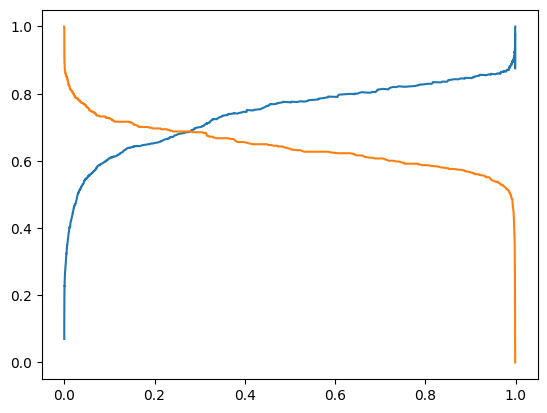

Crossover at 0.28 with recall 0.69
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.69      0.69      0.69       448

    accuracy                           0.96      6393
   macro avg       0.83      0.83      0.83      6393
weighted avg       0.96      0.96      0.96      6393



In [65]:
# Predict probabilities for the test set
y_pred = model.predict(x_test)

# Calculate precision, recall, and thresholds using the precision-recall curve
pc, rc, threshold = precision_recall_curve(y_test, y_pred)
plt.plot(threshold, pc[1:], label='Precision')
plt.plot(threshold, rc[1:], label='Recall')
plt.legend()
plt.show()

# Find the index where precision equals recall
crossover_index = np.max(np.where(pc == rc))

# Get the corresponding threshold at this point
crossover_cutoff = threshold[crossover_index]

# Get the recall value at this point
crossover_recall = rc[crossover_index]

# Print the threshold where precision equals recall and the corresponding recall value
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))

# Print the classification report using the threshold where precision equals recall
# Convert the predicted probabilities to binary (0 or 1) using the crossover threshold
print(classification_report(y_test, y_pred > crossover_cutoff))


In [ ]:
################################################### END OF NOTEBOOK ###################################################